# Creating spatial outputs for localized area (Washington) over 50 ensemble members
### Showing the Absolute Change (2031-2060) - (1991-2020) climatology

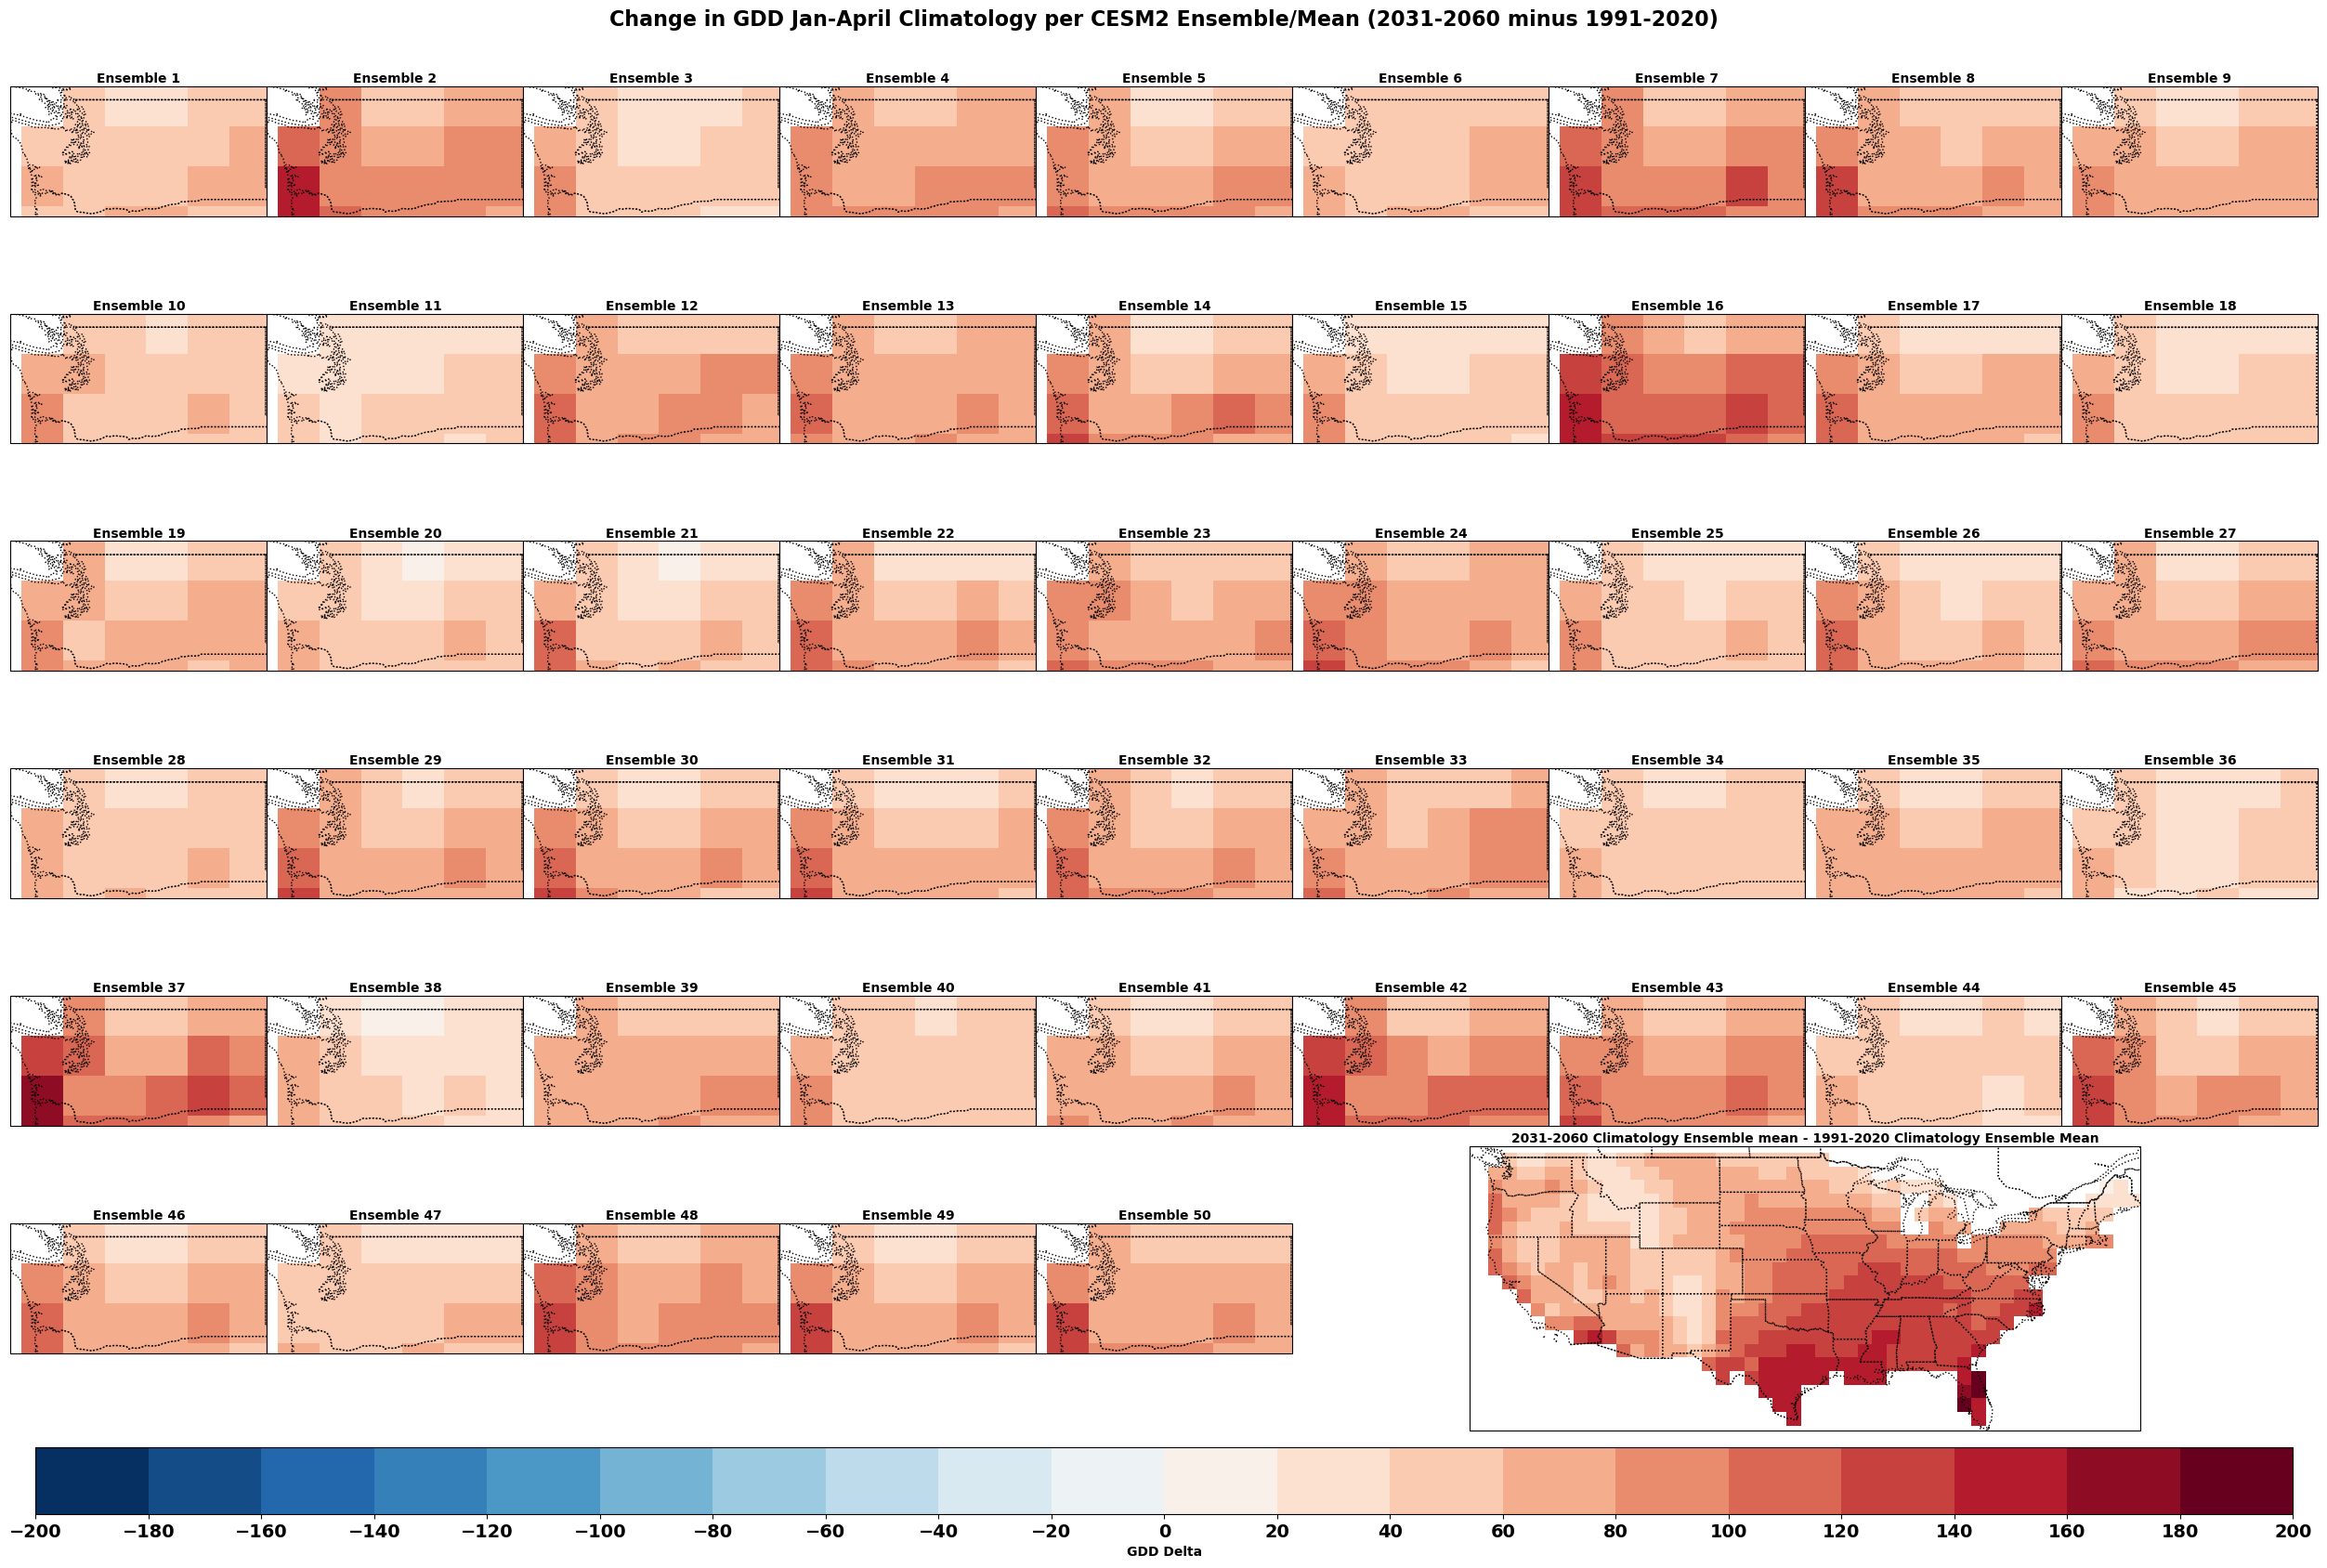

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import matplotlib as mpl
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import geopandas as gpd
import regionmask

# Load the data from NetCDF files
ds_1991_2020 = xr.open_dataset('/home/shawn_preston/gddcesm2janapr/GDD_1991_2020.nc')
ds_2031_2060 = xr.open_dataset('/home/shawn_preston/gddcesm2janapr/GDD_2031_2060.nc')


# Load the shapefile
gdf = gpd.read_file('/home/shawn_preston/shapefile_nation/combined_conus.shp')
# If you already have 2D longitude and latitude arrays, you can skip this step
lon_1d = ds_1991_2020['lon'].values  # Use .values to get a numpy array
lat_1d = ds_1991_2020['lat'].values

mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)


# Extract the GDD values for each ensemble member
gdd_1991_2020_ensemble = ds_1991_2020['gdd_ensemble_1991_2020']
gdd_2031_2060_ensemble = ds_2031_2060['gdd_ensemble_2031_2060']  
# Create a region mask using the shapefile
mask = regionmask.mask_geopandas(gdf, lon_1d, lat_1d)
# If you already have 2D longitude and latitude arrays, you can skip this step
lon_1d = ds_1991_2020['lon'].values  # Use .values to get a numpy array
lat_1d = ds_1991_2020['lat'].values

# Calculate the change (delta GDD) for each ensemble member
delta_gdd_ensemble_members = gdd_2031_2060_ensemble - gdd_1991_2020_ensemble

# Extract the ensemble mean GDD values
ensemble_mean_1991_2020 = ds_1991_2020['gdd_ensemble_mean_1991_2020']
ensemble_mean_2031_2060 = ds_2031_2060['gdd_ensemble_mean_2031_2060'] 

# Calculate the change (delta GDD) for the ensemble mean
delta_gdd_ensemble_mean = ensemble_mean_2031_2060 - ensemble_mean_1991_2020

# Define the boundaries for the discrete intervals for the delta
boundaries = np.linspace(-200, 200, 21)  # Example boundaries for delta GDD
ticks = np.linspace(-200, 200, 21)  # Example ticks for delta GDD

# Create a diverging color map for the delta GDD
cmap = plt.get_cmap('RdBu_r', len(boundaries) - 1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
# Define the boundaries for the discrete intervals for the delta of the ensemble mean
mean_boundaries = np.linspace(-200, 200, 21)  # Smaller range for ensemble mean delta GDD
mean_ticks = np.linspace(-200, 200, 21)  # Fewer ticks for ensemble mean delta GDD

#Create a color map and norm object for the ensemble members
member_cmap = plt.get_cmap('RdBu_r', len(mean_boundaries) - 1)
member_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

#Create a norm object for the ensemble mean
mean_norm = mpl.colors.BoundaryNorm(mean_boundaries, member_cmap.N)

nrows, ncols = 6, 9
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'wspace':0, 'hspace':-0.2})  # Adjusted hspace for minimal spacing

# Loop over the axes and create the maps for the first 50 ensembles
for i, ax in enumerate(axes.flat[:50]):
    ax.set_extent([-124.7, -117, 45.5, 49.4], ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    
    delta_gdd = delta_gdd_ensemble_members[i] / 30
    delta_gdd_masked = np.where(mask == 0, delta_gdd, np.nan)
    
    pcm = ax.pcolormesh(lon_1d, lat_1d, delta_gdd_masked, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    #cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0, aspect=60, shrink=1, boundaries=boundaries, ticks=ticks)
    #cbar.ax.tick_params(labelsize=8)
    ax.set_title(f'Ensemble {i + 1}', fontsize=10, pad=3, weight='bold')

# Remove all axes after the 50 plots of ensembles
for ax in axes.flat[50:]:
    ax.remove()
start_col_for_mean = ncols - 4  # if you want it to span 5 columns
colspan_for_mean = 4  # the actual number of columns to span

# Use ncols in the place of 10 for colspan when you're spanning all columns.
ensemble_mean_change_ax = plt.subplot2grid(
    (nrows, ncols), 
    (nrows - 1, start_col_for_mean), 
    colspan=colspan_for_mean, 
    projection=ccrs.PlateCarree())

ensemble_mean_change_ax.set_extent([-126, -67, 25, 50], ccrs.PlateCarree())
ensemble_mean_change_ax.add_feature(cfeature.BORDERS, linestyle=':')
ensemble_mean_change_ax.add_feature(cfeature.STATES, linestyle=':')
delta_gdd_mean_masked = np.where(mask == 0, delta_gdd_ensemble_mean, np.nan)

pcm_mean = ensemble_mean_change_ax.pcolormesh(
    lon_1d, 
    lat_1d, 
    delta_gdd_mean_masked, 
    transform=ccrs.PlateCarree(), 
    cmap=member_cmap, 
    norm=mean_norm
)

ensemble_mean_change_ax.set_title('2031-2060 Climatology Ensemble mean - 1991-2020 Climatology Ensemble Mean', fontsize=10, pad=3, weight='bold')

# Set the subplot titles and add the gridlines only to the edge subplots
for i, ax in enumerate(axes.flat):
    if i < 50:
        ax.set_title(f'Ensemble {i + 1}', fontsize=10, pad=3, weight='bold')
    else:
        ax.set_visible(False)

# Create the colorbar for the ensemble mean with its unique boundaries and ticks
cbar_ax = fig.add_axes([0.05, 0.1, 0.9, 0.04])  # This will stretch the colorbar across the figure
cbar = fig.colorbar(pcm_mean, cax=cbar_ax, orientation='horizontal', 
                    boundaries=boundaries, ticks=ticks)
cbar.ax.tick_params(labelsize=14)  # This will make the tick labels bold
cbar.set_label('GDD Delta',weight = 'bold')
# Bold the tick labels
for label in cbar.ax.get_xticklabels():
    label.set_fontweight('bold')

# Adjust subplot_adjust to further fine-tune if necessary
plt.subplots_adjust(top=1, bottom=0.15, left=0.04, right=0.96)  # Adjust margins
plt.suptitle('Change in GDD Jan-April Climatology per CESM2 Ensemble/Mean (2031-2060 minus 1991-2020)', 
             fontsize=16, weight='bold', y=1)

#plt.savefig('changeinGDDCESM2janapril.png', dpi = 300, bbox_inches = 'tight')
# Show or save the figure
plt.show()


# Absolute change spread over each ensemble member with mean 

/home/shawn_preston/.conda/envs/jupyter_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shawn_preston/.conda/envs/jupyter_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shawn_preston/.conda/envs/jupyter_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


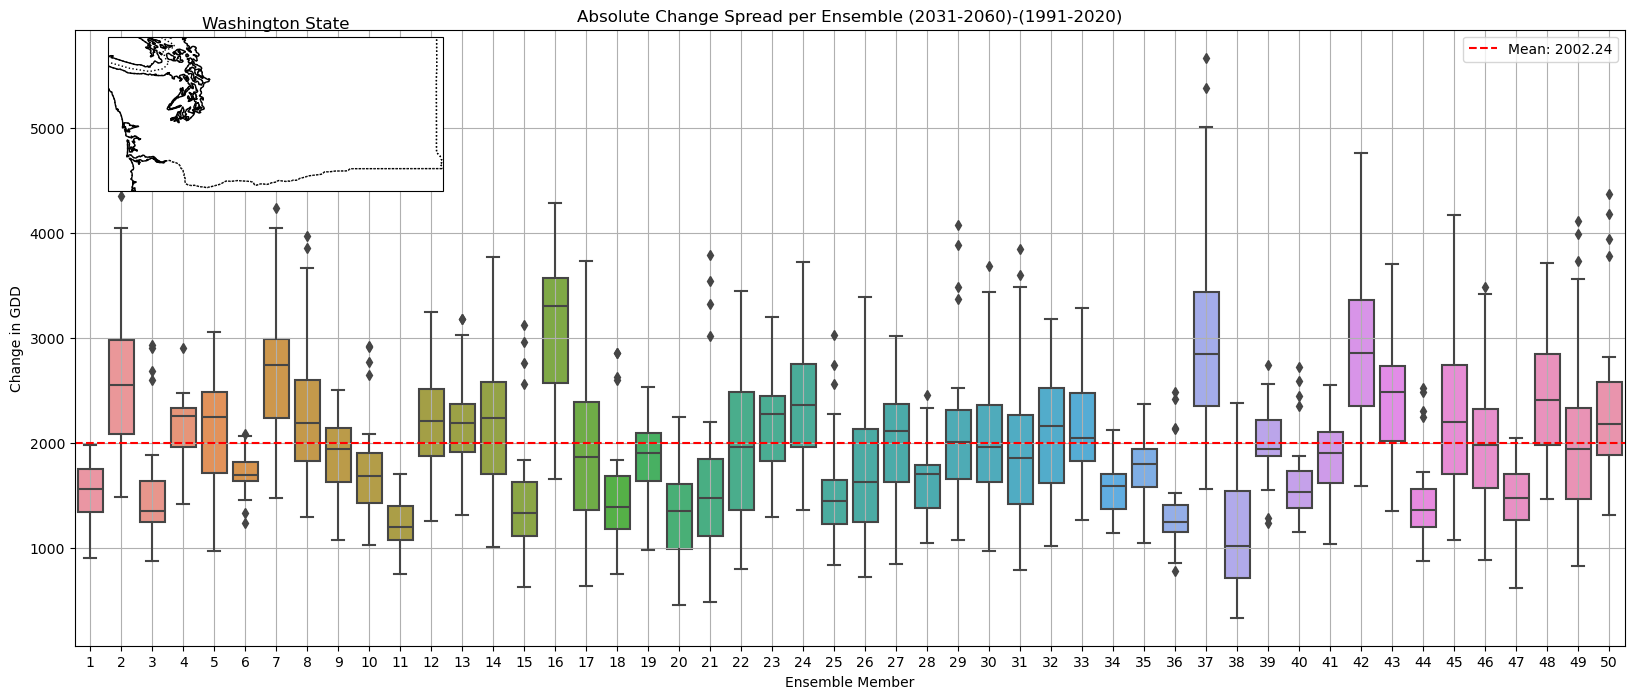

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.mpl.geoaxes
import pandas as pd
# Generate mesh grids for latitude and longitude
lat_2d, lon_2d = np.meshgrid(lat_1d, lon_1d, indexing='ij')

# Define the geographic boundaries (Washington State approximate)
lat_bounds = (46, 49)  # Rough latitude bounds for Washington
lon_bounds = (235, 244)  # Rough longitude bounds for Washington in 0-360 lon

# Create masks based on bounds
lat_mask = (lat_2d >= lat_bounds[0]) & (lat_2d <= lat_bounds[1])
lon_mask = (lon_2d >= lon_bounds[0]) & (lon_2d <= lon_bounds[1])

# Combine latitude and longitude masks
mask_washington = lat_mask & lon_mask


# Calculate indices for latitude and longitude within the bounds
lat_indices = np.where((lat_1d >= lat_bounds[0]) & (lat_1d <= lat_bounds[1]))[0]
lon_indices = np.where((lon_1d >= lon_bounds[0]) & (lon_1d <= lon_bounds[1]))[0]

# Select the relevant subset of the GDD change data
delta_gdd_ensemble_washington = delta_gdd_ensemble_members.isel(lat=lat_indices, lon=lon_indices)

# Flatten the data to a 1D array for plotting, removing NaNs
delta_gdd_ensemble_washington_flat = delta_gdd_ensemble_washington.values.flatten()
delta_gdd_ensemble_washington_flat = delta_gdd_ensemble_washington_flat[~np.isnan(delta_gdd_ensemble_washington_flat)]

# Flatten the data for each ensemble member while preserving the ensemble dimension
flattened_data = delta_gdd_ensemble_washington.stack(z=('lat', 'lon'))

# Initialize a DataFrame to hold the flattened data for plotting
ensemble_gdd_changes = []

# Go through each ensemble member, flatten the data, and store it in the list with the ensemble member label
for i in range(flattened_data.ensemble.size):
    ensemble_data = flattened_data.isel(ensemble=i).values.flatten()
    ensemble_data = ensemble_data[~np.isnan(ensemble_data)]  # Remove NaNs
    ensemble_gdd_changes.append(pd.DataFrame({
        'Ensemble Member': np.repeat(i+1, ensemble_data.size),
        'GDD Change': ensemble_data
    }))

# Concatenate all ensemble member DataFrames
df_gdd_changes = pd.concat(ensemble_gdd_changes, ignore_index=True)

# Your existing box plot setup
plt.figure(figsize=(20, 8))
ax_main = sns.boxplot(data=df_gdd_changes, x='Ensemble Member', y='GDD Change')
plt.title('Absolute Change Spread per Ensemble (2031-2060)-(1991-2020)')
plt.xlabel('Ensemble Member')
plt.ylabel('Change in GDD')
plt.grid(True)

# Calculate the mean of 'High Heat Day Change'
mean_growing_degree_days = np.mean(df_gdd_changes['GDD Change'])

# Add a red dashed line at the mean
ax_main.axhline(mean_growing_degree_days, color='red', linestyle='--', label=f'Mean: {mean_growing_degree_days:.2f}')
ax_main.legend()  


# Create an inset axis with geographic projection
ax_inset = inset_axes(ax_main, width="25%", height="25%", loc='upper left', 
                      axes_class=cartopy.mpl.geoaxes.GeoAxes,
                      axes_kwargs=dict(projection=ccrs.PlateCarree()))

ax_inset.set_extent([-124.5, -116.9, 45.5, 49], crs=ccrs.PlateCarree())
ax_inset.add_feature(cfeature.BORDERS, linestyle=':')
ax_inset.add_feature(cfeature.STATES, linestyle=':')
ax_inset.coastlines(resolution='10m')

# Optionally, add more geographic detail or context
ax_inset.set_title("Washington State")

plt.show()
